In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import sys
import numpy as np
import os
import torch
import json
import time

sys.path.append(os.sep.join(os.getcwd().split("/")[:-1] + ["src"]))

In [3]:
from app.dl_model.model.predictor import YoloV5Predictor, ClassifierPredictor
from app.dl_model.utils import ImageUtilities
from app.dl_model.image import YoloInput

# Setup Model

In [4]:
YoloV5Predictor.setup_model(
    model_path="/Users/koombea/Desktop/emanuel"
    "/tienda-deep-learning-project/serve/models/224_mvp.pt",
    class_names=["items"],
    anchors = [
        [10,13, 16,30, 33,23], # P3/8
        [30,61, 62,45, 59,119], # P4/16
        [116,90, 156,198, 373,326] # P5/32
    ]
)

ClassifierPredictor.setup_model(
    model_path="/Users/koombea/Desktop/emanuel"
    "/tienda-deep-learning-project/serve/models/mobilenetv3.pt",
    class_names=["Arroz Doble Vitamor Diana x 500 g",
                 "CocaCola x 250 ml",
                 "Maracuya",
                 "Chicharrón Americano Jacks x 15 g",
                 "CocaCola x 400 ml",
                 "Papas de limón 39gr"],
    product_external_ids=[29856, 30978, 31742, 32057, 30981, 32191]
)

# Using YoloInput

In [23]:
yolo_input = YoloInput.from_file(file_path="10.jpg", new_shape=(224, 224))

## Visualize input image

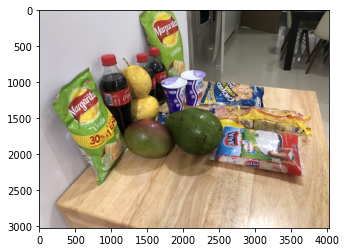

In [24]:
import matplotlib.pyplot as plt
plt.imshow(yolo_input.numpy_image[:, :, ::-1])
plt.show()

# Detect Products

In [25]:
%%time
detected_objects = yolo_input.detect_products(conf_thres=0.1)
print(json.dumps(detected_objects, ensure_ascii=False, indent=3))

{
   "total_classes": 6,
   "detected_products": [
      {
         "product_id": 32191,
         "detection_index": 5,
         "product_name": "Papas de limón 39gr",
         "confidence": 1.0,
         "bounding_box": [
            212,
            909,
            1085,
            2340
         ]
      },
      {
         "product_id": 29856,
         "detection_index": 0,
         "product_name": "Arroz Doble Vitamor Diana x 500 g",
         "confidence": 1.0,
         "bounding_box": [
            2492,
            1649,
            3663,
            2327
         ]
      },
      {
         "product_id": 30981,
         "detection_index": 4,
         "product_name": "CocaCola x 400 ml",
         "confidence": 0.9553656578063965,
         "bounding_box": [
            862,
            612,
            1270,
            1527
         ]
      },
      {
         "product_id": 31742,
         "detection_index": 2,
         "product_name": "Maracuya",
         "confidence": 1.0,
   

# Visualize `detected_objects` response

In [34]:
from typing import Tuple, List
import cv2

class Colors:
    # Ultralytics color palette https://ultralytics.com/
    def __init__(self):
        # hex = matplotlib.colors.TABLEAU_COLORS.values()
        hex = ('FF3838', 'FF9D97', 'FF701F', 'FFB21D', 'CFD231', '48F90A', '92CC17', '3DDB86', '1A9334', '00D4BB',
               '2C99A8', '00C2FF', '344593', '6473FF', '0018EC', '8438FF', '520085', 'CB38FF', 'FF95C8', 'FF37C7')
        self.palette = [self.hex2rgb('#' + c) for c in hex]
        self.n = len(self.palette)

    def __call__(self, i, bgr=False):
        c = self.palette[int(i) % self.n]
        return (c[2], c[1], c[0]) if bgr else c

    @staticmethod
    def hex2rgb(h):  # rgb order (PIL)
        return tuple(int(h[1 + i:1 + i + 2], 16) for i in (0, 2, 4))

def find_best_number(number:int) -> int:
    for i in range(2, number):
        if number % i == 0:
            return i
    return 4

def get_subplots_config(total_images:int,
                        max_ncols:int = None,
                        max_nrows:int = None) -> Tuple[int, int, int]:
    use_cols = True
    
    if max_ncols is None and max_nrows is None:
        max_ncols = find_best_number(total_images)
    elif max_ncols is not None and max_nrows is None:
        use_cols = True
    elif max_ncols is None and max_nrows is not None:
        use_cols = False
    elif max_ncols is not None and max_nrows is not None:
        if total_images > (max_ncols*max_nrows):
            total_images = max_ncols*max_nrows
        
    if use_cols:
        if total_images%max_ncols == 0:
            nrows = total_images // max_ncols
        else:
            nrows = total_images // max_ncols + 1
            
        if total_images - max_ncols >= 0:
            ncols = max_ncols
        else:
            ncols = total_images
    else:
        if total_images%max_nrows == 0:
            ncols = total_images // max_nrows
        else:
            ncols = total_images // max_nrows + 1
            
        if total_images - max_nrows >= 0:
            nrows = max_nrows
        else:
            nrows = total_images
            
    return nrows, ncols, total_images

def plots_multiple_tensor_image(*numpy_images, title_name:List[str]=None,
                                ncols:int=None, nrows:int=None,
                                figsize:Tuple[int, int]=(14, 10)):
    total_images = len(numpy_images)
    
    if total_images > len(title_name):
        extras = total_images - len(title_name)
        title_name.extend(range(extras))
        
    if ncols is None and nrows is None:
        nrows, ncols, total_images = get_subplots_config(total_images)
    elif ncols is not None and nrows is None:
        nrows, ncols, total_images = get_subplots_config(total_images,
                                                         max_ncols=ncols)
    elif ncols is None and nrows is not None:
        nrows, ncols, total_images = get_subplots_config(total_images,
                                                         max_nrows=nrows)
    elif ncols is not None and nrows is not None:
        nrows, ncols, total_images = get_subplots_config(total_images,
                                                         max_nrows=nrows,
                                                         max_ncols=ncols)
    
    if title_name[0] is None:
        title_name = list(range(total_images))
        
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                           figsize=figsize, tight_layout=True)
    if nrows == 1 and ncols == 1:
        ax = [[ax]]
    elif nrows == 1:
        ax = ax.reshape(1, -1)
    elif ncols == 1:
        ax = ax.reshape(-1, 1)
    
    idx_image = 0
    for i in range(nrows):
        for j in range(ncols):
            if idx_image >= total_images:
                return
            else:
                image_array = numpy_images[idx_image]
                if image_array.max() > 1:
                    image_array = image_array.astype(np.uint8)
                else:
                    image_array = image_array.astype(np.float32)
                    
                ax[i][j].set_title(title_name[idx_image])
                if len(image_array.shape) == 2:
                    ax[i][j].imshow(image_array, cmap="gray")
                else:
                    ax[i][j].imshow(image_array)
            idx_image += 1
    plt.show()
    
def visualize_crop_images(image:np.ndarray,
                           detected_objects: dict,
                           **kwargs):
    titles = ["original image"] + [(f'name: {detected_object["product_name"]}' 
                                   f' - conf: {detected_object["confidence"]:0.2f}')
              for detected_object in detected_objects["detected_products"]]
    coordinates = [detected_object["bounding_box"] 
                  for detected_object in detected_objects["detected_products"]]
    numpy_images = [image] + [image[y1:y2,x1:x2,:].copy() for x1,y1,x2,y2 in coordinates]
    plots_multiple_tensor_image(*numpy_images, title_name=titles, **kwargs)
    
def draw_one_bounding_box(
        numpy_image:np.ndarray,
        label:str,
        top_left: Tuple[int, int],
        bottom_right: Tuple[int, int],
        color: Tuple[int, int, int],
        tl: int):
    cv2.rectangle(image, top_left, bottom_right, color, thickness=tl, lineType=cv2.LINE_AA)
    tf = max(tl - 1, 1)  # font thickness
    t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
    bottom_right = top_left[0] + t_size[0], top_left[1] - t_size[1] - 3
    cv2.rectangle(image, top_left, bottom_right, color, -1, cv2.LINE_AA)  # filled
    cv2.putText(image, label, (top_left[0], top_left[1] - 2), 0, tl / 3,
                [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    
def visualize_bounding_boxes(image:np.ndarray,
                             detected_objects: dict,
                             **kwargs):
    image_temp = image.copy()
    colors = Colors()
    titles = [(f'{detected_object["product_name"]}-{detected_object["confidence"]:0.2f}')
              for detected_object in detected_objects["detected_products"]]
    coordinates = [detected_object["bounding_box"] 
                  for detected_object in detected_objects["detected_products"]]
    cls_indexes = [detected_object["detection_index"]
                  for detected_object in detected_objects["detected_products"]]
    tl = round(0.002 * (image.shape[0] + image.shape[1]) / 2) + 1  # line/font thickness
    
    for index, coords in enumerate(coordinates):
        c = cls_indexes[index]
        draw_one_bounding_box(
            image_temp, label=titles[index],
            top_left=tuple(coords[:2]), bottom_right=tuple(coords[2:]),
            color=colors(c, True), tl=tl
        )
    
    plots_multiple_tensor_image(image, image_temp, title_name=["original image", "image with boxes"], **kwargs)
        

## Visualize bounding boxes in image

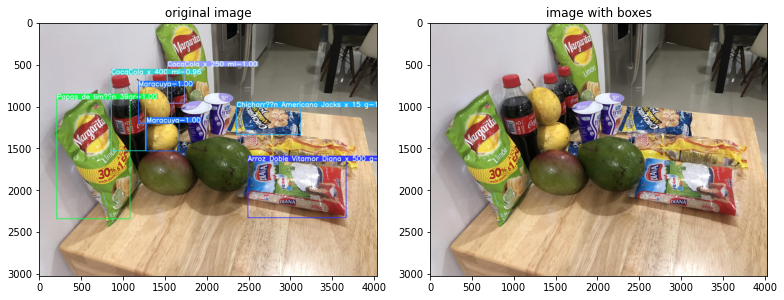

In [35]:
image = np.ascontiguousarray(yolo_input.numpy_image[:, :, ::-1])
visualize_bounding_boxes(image, detected_objects, figsize=(11, 5))

## Visualize crop detected images

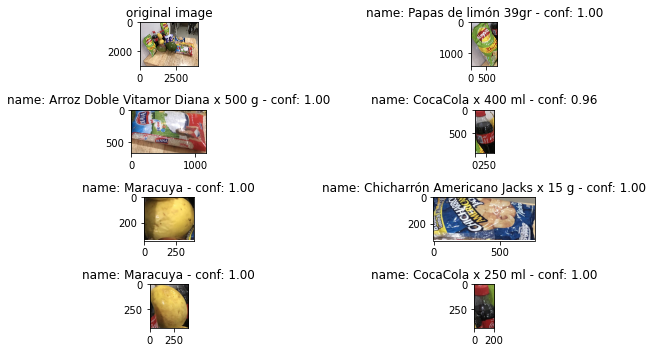

In [36]:
image = np.ascontiguousarray(yolo_input.numpy_image[:, :, ::-1])
visualize_crop_images(image, detected_objects, figsize=(11, 5))